In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


In [2]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())


In [3]:
from policy import PolicyNN
model = PolicyNN(
    past_input_dim=6,
    future_input_dim=6,
    output_dim=1,
    p=50,
    window=50,
    hidden_dim=1024,
    n_layers=3,
    dropout_p=0.1
).to(device)

model.load_state_dict(torch.load("/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_model_discreteshift_3L_1024H_s1_c0_case19.pth", map_location="cpu"))
model.eval()

PolicyNN(
  (input_layer): Linear(in_features=600, out_features=1024, bias=True)
  (input_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (norm_layers): ModuleList(
    (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (output_layer): Linear(in_features=1024, out_features=50, bias=True)
)

In [4]:
import numpy as np
import pandas as pd
from typing import Optional, Tuple
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")


import shutil
import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

from nn_functions import surrogate
from moving_average import moving_average_1d
import copy
from GAMMA_obj_temp_depth import GAMMA_obj


cuda is available


In [5]:
device = torch.device("cuda:0")

# ── Constants ─────────────────────────────────────
INPUT_DATA_DIR = "data"
SIM_DIR_NAME = "single_track_square"
BASE_LASER_FILE_DIR = "laser_power_profiles/csv"
CLOUD_TARGET_BASE_PATH = "result"
solidus_temp = 1600
window = 50
sim_interval = 5
init_runs = 50
P = 50

model_path = "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_model_discreteshift_0.0001_3L_1024H_s1_c3.pth"


In [6]:
import torch

# values from user
x_min = torch.tensor([[0.0, 0.75, 0.75, 504.26]], dtype=torch.float32).to(device)
x_max = torch.tensor([[7.5, 20.0, 20.0, 732.298]], dtype=torch.float32).to(device)

y_min = torch.tensor([[436.608, -0.559]], dtype=torch.float32).to(device)
y_max = torch.tensor([[4509.855, 0.551]], dtype=torch.float32).to(device)

def normalize_x(x, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 2 * (x - x_min_selected) / (x_max_selected - x_min_selected) - 1

def inverse_normalize_x(x_norm, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 0.5 * (x_norm + 1) * (x_max_selected - x_min_selected) + x_min_selected

def normalize_y(y, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 2 * (y - y_min_selected) / (y_max_selected - y_min_selected) - 1

def inverse_normalize_y(y_norm, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 0.5 * (y_norm + 1) * (y_max_selected - y_min_selected) + y_min_selected



In [7]:
import copy
import torch

def simulate_policy_horizon_for_visualization(GAMMA_obj, policy_model, TiDE, P, window):
    """
    Returns:
        - tide_temp_pred: [50], inverse normalized
        - tide_depth_pred: [50], inverse normalized
        - gamma_temp_sim: [50], inverse normalized
        - gamma_depth_sim: [50], inverse normalized
        - u_seq: [50], inverse normalized
    """
    # ── 1. Policy Input (normalized) ──────────────────────
    mp_temp_ref = GAMMA_obj.ref[GAMMA_obj.MPC_counter:GAMMA_obj.MPC_counter + P]
    mp_temp_ref_t = torch.tensor(mp_temp_ref, dtype=torch.float32, device=device).reshape(1, P, 1)

    mp_temp_past_t = GAMMA_obj.x_past.T.unsqueeze(0).to(device)  # [1, 50, 2]
    laser_past_t = GAMMA_obj.u_past.view(1, -1, 1).to(device)     # [1, 50, 1]

    fix_cov_past = GAMMA_obj.fix_cov_all[GAMMA_obj.MPC_counter - window:GAMMA_obj.MPC_counter, :]
    fix_cov_future = GAMMA_obj.fix_cov_all[GAMMA_obj.MPC_counter:GAMMA_obj.MPC_counter + P, :]

    fix_cov_past_t = torch.tensor(fix_cov_past, dtype=torch.float32, device=device).unsqueeze(0)
    fix_cov_future_t = torch.tensor(fix_cov_future, dtype=torch.float32, device=device).unsqueeze(0)

    fix_cov_past_s = normalize_x(fix_cov_past_t, dim_id=[0, 1, 2])
    fix_cov_future_s = normalize_x(fix_cov_future_t, dim_id=[0, 1, 2])
    laser_past_s = normalize_x(laser_past_t, dim_id=[3])
    mp_temp_past_s = normalize_y(mp_temp_past_t, dim_id=[0, 1])
    mp_temp_ref_s = normalize_y(mp_temp_ref_t, dim_id=[0])[:, :, 0].unsqueeze(-1)

    depth_lower_const = 0.1423
    depth_upper_const = 0.4126
    y_const_s = torch.tensor([[depth_lower_const, depth_upper_const]] * P,
                             dtype=torch.float32, device=device).reshape(1, P, 2)

    policy_in_past = torch.cat((fix_cov_past_s, laser_past_s, mp_temp_past_s), dim=2)  # [1, 50, 6]
    policy_in_future = torch.cat((fix_cov_future_s, mp_temp_ref_s, y_const_s), dim=2)  # [1, 50, 6]

    # ── 2. Policy → u_seq (normalized + denormalized) ─────
    with torch.no_grad():
        u_pred = policy_model((policy_in_past, policy_in_future))  # [1, 50, 1]
        u_seq_norm = u_pred[0]  # [50, 1]
        u_seq = inverse_normalize_x(u_seq_norm, dim_id=[3])  # [50, 1]

    # ── 3. TiDE prediction (past_cov, future_cov, None) ───
    past_cov = torch.cat((mp_temp_past_s, fix_cov_past_s, laser_past_s), dim=2)
    future_cov = torch.cat((fix_cov_future_s, u_pred.to(device)), dim=2)

    with torch.no_grad():
        print(past_cov)
        print(future_cov)

        tide_out = TiDE((past_cov, future_cov, None))  # [1, 50, quantile, 2]
        tide_out_med = tide_out[:, :, :, 1].squeeze(0)  # [50, 2]
        tide_temp_pred = inverse_normalize_y(tide_out_med[:, 0], dim_id=[0])
        tide_depth_pred = inverse_normalize_y(tide_out_med[:, 1], dim_id=[1])

    return (
        tide_temp_pred.cpu().numpy(),   # [50]
        tide_depth_pred.cpu().numpy(),  # [50]
        u_seq.cpu().numpy()            # [50, 1]
    )
     
'''
    # ── 4. GAMMA 시뮬레이션 (cumulative update) ────────────
    gamma_temp_sim = []
    gamma_depth_sim = []

    gamma_copy = copy.deepcopy(GAMMA_obj)
    for i in range(P):
        u_val = float(u_seq[i].item())
        x_t, d_t = gamma_copy.run_sim_interval(u_val)

        gamma_temp_sim.append(x_t)
        gamma_depth_sim.append(d_t)

        # 누적 시계열 업데이트
        x_new = torch.tensor([[x_t], [d_t]], dtype=torch.float32, device=device)
        u_new = torch.tensor([u_val], dtype=torch.float32, device=device)

        gamma_copy.x_past = torch.cat([gamma_copy.x_past[:, 1:], x_new], dim=1)
        gamma_copy.u_past = torch.cat([gamma_copy.u_past[1:], u_new], dim=0)

    return (
        tide_temp_pred.cpu().numpy(),   # [50]
        tide_depth_pred.cpu().numpy(),  # [50]
        #np.array(gamma_temp_sim),      # [50]
        #np.array(gamma_depth_sim),     # [50]
        u_seq.cpu().numpy()            # [50, 1]
    )
'''


'\n    # ── 4. GAMMA 시뮬레이션 (cumulative update) ────────────\n    gamma_temp_sim = []\n    gamma_depth_sim = []\n\n    gamma_copy = copy.deepcopy(GAMMA_obj)\n    for i in range(P):\n        u_val = float(u_seq[i].item())\n        x_t, d_t = gamma_copy.run_sim_interval(u_val)\n\n        gamma_temp_sim.append(x_t)\n        gamma_depth_sim.append(d_t)\n\n        # 누적 시계열 업데이트\n        x_new = torch.tensor([[x_t], [d_t]], dtype=torch.float32, device=device)\n        u_new = torch.tensor([u_val], dtype=torch.float32, device=device)\n\n        gamma_copy.x_past = torch.cat([gamma_copy.x_past[:, 1:], x_new], dim=1)\n        gamma_copy.u_past = torch.cat([gamma_copy.u_past[1:], u_new], dim=0)\n\n    return (\n        tide_temp_pred.cpu().numpy(),   # [50]\n        tide_depth_pred.cpu().numpy(),  # [50]\n        #np.array(gamma_temp_sim),      # [50]\n        #np.array(gamma_depth_sim),     # [50]\n        u_seq.cpu().numpy()            # [50, 1]\n    )\n'

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_tide_vs_gamma_stepwise(t, GAMMA_obj, tide_temp, tide_depth, u_seq, P=50):
    """
    Plots:
    1. Melt pool temperature (TiDE vs GAMMA vs reference)
    2. Melt pool depth (TiDE vs GAMMA)
    3. Laser power input sequence (policy prediction)
    """

    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f"Step {t}: TiDE vs GAMMA Horizon Prediction + Control", fontsize=14)

    # ── Time Axis ──────────────────────
    x_past = np.arange(t - P, t)
    x_future = np.arange(t, t + P)

    # ── Prepare reference and past signals ─────────────
    ref_future = GAMMA_obj.ref[t:t + P].detach().cpu().numpy()
    temp_hist = GAMMA_obj.x_past_save[-P:, 0].detach().cpu().numpy()
    depth_hist = GAMMA_obj.x_past_save[-P:, 1].detach().cpu().numpy()
    u_past = GAMMA_obj.u_past_save[-P:].detach().cpu().numpy().flatten()

    tide_temp = tide_temp.detach().cpu().numpy() if torch.is_tensor(tide_temp) else tide_temp
    tide_depth = tide_depth.detach().cpu().numpy() if torch.is_tensor(tide_depth) else tide_depth
    #gamma_temp = gamma_temp.detach().cpu().numpy() if torch.is_tensor(gamma_temp) else gamma_temp
    #gamma_depth = gamma_depth.detach().cpu().numpy() if torch.is_tensor(gamma_depth) else gamma_depth
    u_seq = u_seq.detach().cpu().numpy().flatten() if torch.is_tensor(u_seq) else u_seq

    # ── Temperature Plot ────────────────
    axs[0].plot(x_past, temp_hist, label="GAMMA (past)", color='black')
    axs[0].plot(x_future, ref_future, label="Reference", linestyle=':', color='gray')
    axs[0].plot(x_future, tide_temp, label="TiDE (pred)", linestyle='--', color='blue')
    #axs[0].plot(x_future, gamma_temp, label="GAMMA (sim)", linestyle='-', color='red')
    axs[0].set_ylabel("Melt Pool Temperature (K)")
    axs[0].legend()
    axs[0].grid(True)

    # ── Depth Plot ──────────────────────
    axs[1].plot(x_past, depth_hist, label="GAMMA (past)", color='black')
    axs[1].plot(x_future, tide_depth, label="TiDE (pred)", linestyle='--', color='blue')
    #axs[1].plot(x_future, gamma_depth, label="GAMMA (sim)", linestyle='-', color='red')
    axs[1].set_ylabel("Melt Pool Depth (mm)")
    axs[1].legend()
    axs[1].grid(True)

    # ── Control Input Plot ──────────────
    axs[2].plot(x_past, u_past, label="Laser Power (past)", color='black')
    axs[2].plot(x_future, u_seq, label="Laser Power (predicted)", linestyle='--', color='green')
    axs[2].set_ylabel("Laser Power")
    axs[2].set_xlabel("Time Step")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


In [9]:
import pandas as pd
import numpy as np
import torch

def load_GAMMA_state_for_step(t, laser_power_number=2):
    # ── Constants ─────────────────────────────────────
    base_dir = "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725"
    save_dir = f"{base_dir}/simulation_outputs_case21_discrete shift"
    input_csv_path = f"{base_dir}/split_by_laser_power_number/laser_power_number_{laser_power_number}.csv"

    INPUT_DATA_DIR = "data"
    SIM_DIR_NAME = "single_track_square"
    BASE_LASER_FILE_DIR = "laser_power_profiles/csv"
    CLOUD_TARGET_BASE_PATH = "result"
    solidus_temp = 1600
    window = 50
    sim_interval = 5
    init_runs = 50

    # ── Load saved outputs ────────────────────────────
    x_all = pd.read_csv(f"{save_dir}/x_outputs_laser_{laser_power_number}.csv").values  # [N, 2]
    u_all = pd.read_csv(f"{save_dir}/u_outputs_laser_{laser_power_number}.csv").values  # [N, 1]
    ref_all = pd.read_csv(f"{save_dir}/ref_laser_{laser_power_number}.csv").values.flatten()  # [N,]

    # ── Load fix_cov from original input csv ──────────
    df = pd.read_csv(input_csv_path)
    fix_cov_all = df[["Z", "Dist_to_nearest_X", "Dist_to_nearest_Y"]].to_numpy()  # [N, 3]

    # ── Instantiate GAMMA_obj with dummy init ─────────
    GAMMA = GAMMA_obj(INPUT_DATA_DIR, SIM_DIR_NAME, BASE_LASER_FILE_DIR,
                      CLOUD_TARGET_BASE_PATH, solidus_temp, window,
                      init_runs, sim_interval, laser_power_number)

    # ── Overwrite internal state with saved values ───
    GAMMA.MPC_counter = t
    GAMMA.x_past = torch.tensor(x_all[t - window:t].T, dtype=torch.float32, device=device)  # [2, 50]
    GAMMA.u_past = torch.tensor(u_all[t - window:t].flatten(), dtype=torch.float32, device=device)  # [50]
    GAMMA.ref = torch.tensor(ref_all, dtype=torch.float32, device=device)  # [N]
    GAMMA.fix_cov_all = fix_cov_all  # still numpy (used directly)
    GAMMA.x_past_save = torch.tensor(x_all[:t], dtype=torch.float32, device=device)  # [t, 2]
    GAMMA.u_past_save = torch.tensor(u_all[:t], dtype=torch.float32, device=device)  # [t, 1]
    GAMMA.x_hat_current = GAMMA.x_past[:, -1]
    GAMMA.x_sys_current = GAMMA.x_hat_current.view(2, 1)

    GAMMA.initial_average_temp = GAMMA.x_past[0, -1].item()
    GAMMA.initial_average_depth = GAMMA.x_past[1, -1].item()

    return GAMMA


tensor([[[ 0.4084,  0.3519,  0.4000, -1.0000, -0.7935, -0.5929],
         [ 0.4189,  0.3519,  0.4000, -1.0000, -0.8194, -0.5821],
         [ 0.4299,  0.3519,  0.4000, -1.0000, -0.8454, -0.5681],
         [ 0.4276,  0.3657,  0.4000, -1.0000, -0.8714, -0.5516],
         [ 0.4210,  0.4209,  0.4000, -1.0000, -0.8974, -0.5502],
         [ 0.3965,  0.3933,  0.4000, -1.0000, -0.9234, -0.5961],
         [ 0.3707,  0.3244,  0.4000, -1.0000, -0.9494, -0.6071],
         [ 0.3802,  0.2968,  0.4000, -1.0000, -0.9754, -0.5530],
         [ 0.4368,  0.2416,  0.4000, -0.9986, -1.0000, -0.5235],
         [ 0.5042,  0.2692,  0.4000, -0.9726, -1.0000, -0.4967],
         [ 0.5362,  0.3106,  0.4000, -0.9466, -1.0000, -0.5200],
         [ 0.5309,  0.3519,  0.4000, -0.9206, -1.0000, -0.5490],
         [ 0.5091,  0.4347,  0.4000, -0.8946, -1.0000, -0.5860],
         [ 0.4938,  0.4485,  0.4000, -0.8686, -1.0000, -0.6624],
         [ 0.4724,  0.4347,  0.4000, -0.8426, -1.0000, -0.6981],
         [ 0.4615,  0.420

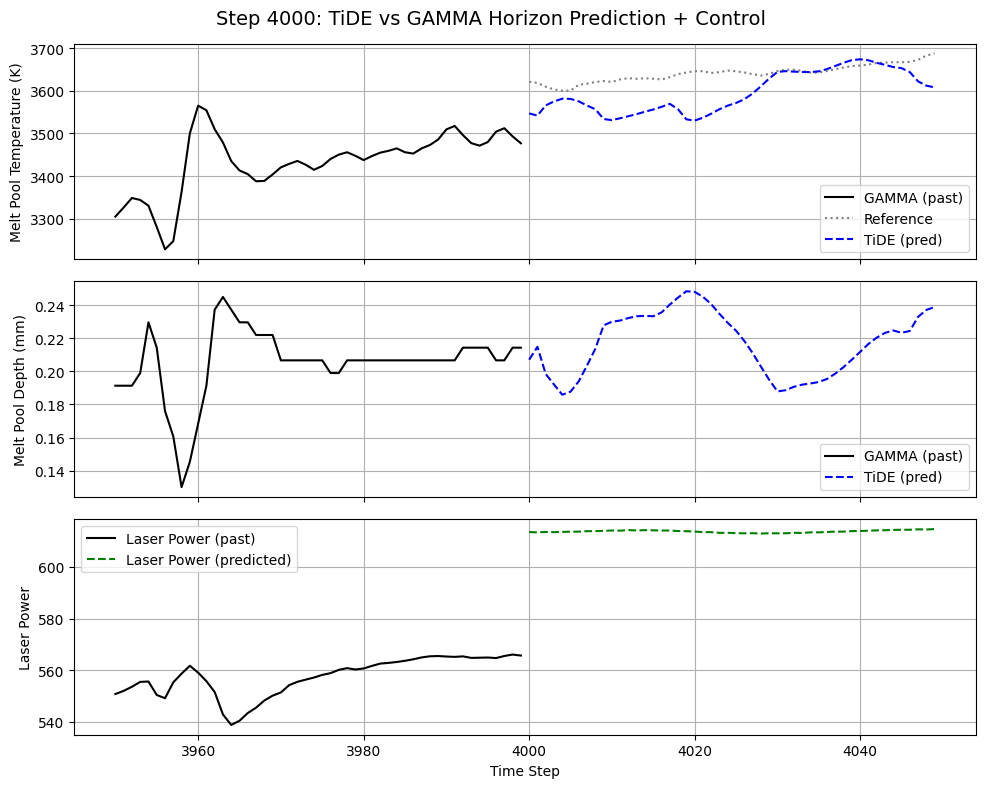

In [10]:
t = 4000
GAMMA_obj = load_GAMMA_state_for_step(t)

tide_temp, tide_depth, u_seq = simulate_policy_horizon_for_visualization(
    GAMMA_obj, policy_model=model, TiDE=TiDE, P=50, window=50
)
plot_tide_vs_gamma_stepwise(t, GAMMA_obj, tide_temp, tide_depth, u_seq, P=50)
